# **Lesson 10**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import HTML
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [6]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params
%matplotlib inline

# Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

## Solution

Parallelizing a code means diving the main task in some secondary problems that can be solved simultaneously, and then solving them with different processors at the same time. This technique allows to better exploit the computational resources (e.g. we can use several cheap processors instead of one last-generation, expensive CPU) and to considerably reduce computational time.

Parallel computing can be done in several ways, depending on if there are one or more fluxes of instructions that can accesses memory in one or multiple location. In this exercise I followed the **Single Program Multiple Data** (SPMD) approach, where the same executable is run over many processors working on different data, and all the processes are connected via one communication buffer to exchange information. To do so I exploited the **MPI** (Message Passing Interface) **library**, which contains several useful functions that I explain below.

- `MPI_Init(int *argc, char **argv)`: this is the initialization instruction for the parallel processes, so it must be called before every other parallel instruction. It takes as input the command line arguments, and uses them to set the desired number of parallel processes, then it links them with the `MPI_COMM_WORLD` communicator.
- `MPI_Finalize()`: terminates all the parallel processes. It is unsafe doing anything before `MPI_Init()` or after `MPI_Finalize()`.
- `MPI_Comm_size(MPI_Comm comm, int *size)`: this instruction initialize the `size` variable, that is the total number of parallel processes. Once this instruction is called, every process becomes 'aware' of how many other processes there are inside the `MPI_Comm` (typically `MPI_COMM_WORLD`). 
- `MPI_Comm_rank(MPI_Comm comm, int *rank)`: this command sets the `rank` of every process, uniquely identifying each of them inside the communicator, i.e., when this command is called every process receives a unique 'name'.
- `MPI_Bcast(void *buffer, int n, MPI_Datatype datatype, int root, MPI_Comm comm)`: this is the broadcasting instruction, that sends `n datatype` elements from the `root` process to all other processes inside the `comm` communicator. The broadcasted data should be passed to this function via a pointer, and typically `datatype` is a standard `MPI` type.
- `MPI_Gather(void *sendbuf, int n_send, MPI_Datatype sendtype, void *recvbuf, int n_recv, MPI_Datatype recvtype, int root, MPI_Comm comm)`: this instruction gathers `n_send sendtype` elements from all the processes of the communicator to one `root` process, that receives `n_recv recvtype` (that obviously should be the same as the sent ones). Again all data must be passed as pointers.
- `MPI_Reduce(void *sendbuf, void *recvbuf, int n, MPI_Datatype datatype, MPI_Op op, int root,  MPI_Comm comm)`: this function is used to reduce `n datatype` elements from all the processes of the communicator to one `root` process, performing an `op` operation on them, e.g. the summation or the research of the global minimum.
- `MPI_Barrier()`: forces all the processes to wait for each other. This is useful for example before a call to `MPI_Gather()`, to prevent the gathering of non-completely processed data.

    

### Code

The implementation of the parallelization is done mainly modifying the `main.cpp` of exercise $09$, and exploiting the `n_migr` variable in the `TSP` class. The output files contain also the rank of the process and are stored in the `Output` directory. I have implemented $4$ parallel search processes.

Here I show some code snippets that may help to understand how I have solved this exercise.

<br>

After having generated the cities on the circle for rank $0$ and inside the square for rank $1$ I broadcasted them on all other processes:
```c++
    int circle_init[1] = {0}, square_init[1] = {0};
    if(rank == 0) {         // rank 0 initialize the cities on the circle
        salesman_circle.Circle();
        circle_init[0] = 1;
    }
    if(rank == 1) {         // rank 1 initialize the cities on the square
        salesman_square.Square();
        square_init[0] = 1;
    }

    // broadcast the message: now all other ranks can read the cities from file
    MPI_Bcast(circle_init, 1, MPI_INTEGER, 0, MPI_COMM_WORLD);
    MPI_Bcast(square_init, 1, MPI_INTEGER, 1, MPI_COMM_WORLD);
```
Note that in this exercise I declared again two different `TSP` objects.

<br>

Inside the evolutive loop, every `n_migr` generations all the processes exchange their best individuals, gathering them at rank $0$, which shuffle them and send them back to other processes:
```c++
if(n_migr != 0 and i%n_migr == 0 and i != 0) {
    salesman_square.Order();
    salesman_circle.Order();

    // all processes wait for each other, then gather all the best paths to process 0, shuffle them and send them back
    MPI_Barrier(MPI_COMM_WORLD);
    MPI_Gather(salesman_circle[0].GetIndex().memptr(), n_cities, MPI_UNSIGNED_LONG_LONG, best_circle.memptr(), n_cities, MPI_UNSIGNED_LONG_LONG, 0, MPI_COMM_WORLD);
    MPI_Gather(salesman_square[0].GetIndex().memptr(), n_cities, MPI_UNSIGNED_LONG_LONG, best_square.memptr(), n_cities, MPI_UNSIGNED_LONG_LONG, 0, MPI_COMM_WORLD);

    if(rank == 0) {
        best_circle = shuffle(best_circle, 1);
        best_square = shuffle(best_square, 1);
    }

    MPI_Barrier(MPI_COMM_WORLD);
    MPI_Bcast(best_circle.memptr(), best_circle.size(), MPI_UNSIGNED_LONG_LONG, 0, MPI_COMM_WORLD);
    MPI_Bcast(best_square.memptr(), best_square.size(), MPI_UNSIGNED_LONG_LONG, 0, MPI_COMM_WORLD);

    salesman_circle[0].SetIndex(best_circle.col(rank));
    salesman_square[0].SetIndex(best_square.col(rank));
}
```

<br>

In the end I search for the best path among all processes and I print the value of the rank that found it, together with its loss:
```c++
// finally, find the best path
double min_cir_local[1] = {salesman_circle[0].GetLoss()};
double min_squ_local[1] = {salesman_square[0].GetLoss()};
double min_cir_global[1];
double min_squ_global[1];

MPI_Barrier(MPI_COMM_WORLD);
MPI_Reduce(min_cir_local, min_cir_global, 1, MPI_DOUBLE, MPI_MIN, 0, MPI_COMM_WORLD);
MPI_Reduce(min_squ_local, min_squ_global, 1, MPI_DOUBLE, MPI_MIN, 0, MPI_COMM_WORLD);
MPI_Bcast(min_cir_global, 1, MPI_DOUBLE, 0, MPI_COMM_WORLD);
MPI_Bcast(min_squ_global, 1, MPI_DOUBLE, 0, MPI_COMM_WORLD);

/* print */
```


I chose to implement the first option of the two proposed, migrating the best individuals every $20$ generations, below I am showing the results.

Best circle process: 2		Loss: 6.24306

Best square process: 1		Loss: 4.32961

In [7]:
rank_cir = 2
rank_squ = 1

In [9]:
i_circ, x_circ, y_circ = np.loadtxt('10.1/cities_circle.tsv', delimiter='\t', skiprows=1, unpack=True, usecols=(0,1,2))
data_circ = np.loadtxt('10.1/Output/opt_circle_rank=' +str(rank_cir)+ '.csv', delimiter=',', skiprows=1)
gens = data_circ[:,0]
#best_losses_circ = data_circ[:,1]
index_circ = np.array(data_circ[:,2:])
loss_circ = np.loadtxt('10.1/Output/loss_circle_rank=' +str(rank_cir)+ '.csv', delimiter=',', skiprows=1)
loss_circ = np.array(loss_circ[:,1:])

i_square, x_square, y_square = np.loadtxt('10.1/cities_square.tsv', delimiter='\t', skiprows=1, unpack=True, usecols=(0,1,2))
data_square = np.loadtxt('10.1/Output/opt_square_rank=' +str(rank_squ)+ '.csv', delimiter=',', skiprows=1)
#gens = data_square[:,0]
#best_losses_square = data_square[:,1]
index_square = np.array(data_square[:,2:])
loss_square = np.loadtxt('10.1/Output/loss_square_rank=' +str(rank_squ)+ '.csv', delimiter=',', skiprows=1)
loss_square = np.array(loss_square[:,1:])

In [10]:
pop_size = int(loss_circ.shape[1])

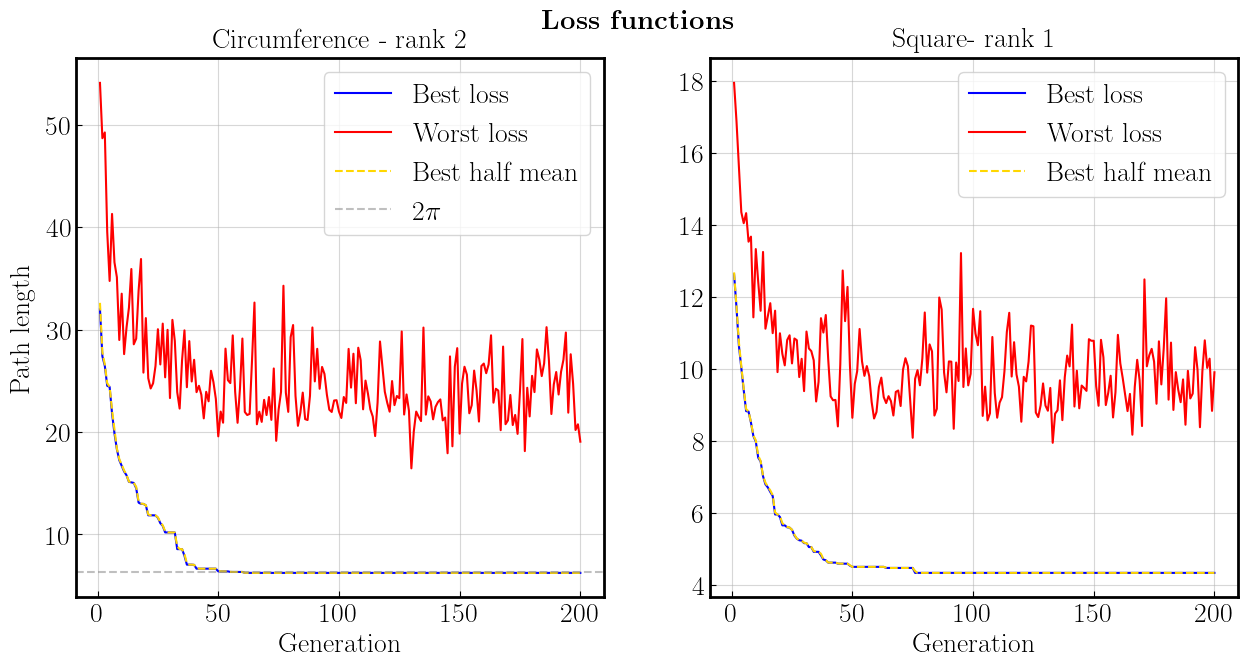

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,7))
plt.suptitle(r'\textbf{Loss functions}', y=0.95)

axs[0].plot(gens, loss_circ[:,0], c='b', label='Best loss')
axs[0].plot(gens, loss_circ[:,-1], c='r', label='Worst loss')
axs[0].plot(gens, np.mean(loss_circ[:,:int(pop_size/2)], axis=1), c='gold', ls='--', label='Best half mean')
axs[0].axhline(2*np.pi, c='grey', ls='--', alpha=0.5, label='$2\pi$')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Path length', labelpad=8)
axs[0].set_title('Circumference - rank ' +str(rank_cir), pad=8)
axs[0].legend()

axs[1].plot(gens, loss_square[:,0], c='b', label='Best loss')
axs[1].plot(gens, loss_square[:,-1], c='r', label='Worst loss')
axs[1].plot(gens, np.mean(loss_square[:,:int(pop_size/2)], axis=1), c='gold', ls='--', label='Best half mean')
axs[1].set_xlabel('Generation')
axs[1].set_title('Square - rank ' +str(rank_squ), pad=8)
axs[1].legend()

plt.show()

This plots show the value of the loss for the search of the best path through $34$ cities on a circumference (left) and in a square (right) as a function of the number of generations. I plotted the values of the best loss, the worst loss and the average value of the best half of the individuals. In the case of the circumference, the value of the loss is compared with $2\pi$. This graphs refers to the ranks that obtained the best result.

We can note that, in both cases, after $100$ generations a good path has been discovered, and that in particular the circumference case the parallelized algorithm converges faster than in exercise $09$.

**Plot parameters**:
- Number of generations: $200$
- Population size: $300$
- Crossover probability: $0.8$
- Pair permutation probability: $0.3$
- Block permutation probability: $0.1$
- Shift probability: $0.2$
- Inversion probability: $0.2$

I calibrated empirically the probabilities for crossover and other mutations, choosing the ones that gave me the best result. In principle this parameters can vary considering a circumference and a square, but in my case this set gave me excellent results in both scenarios.

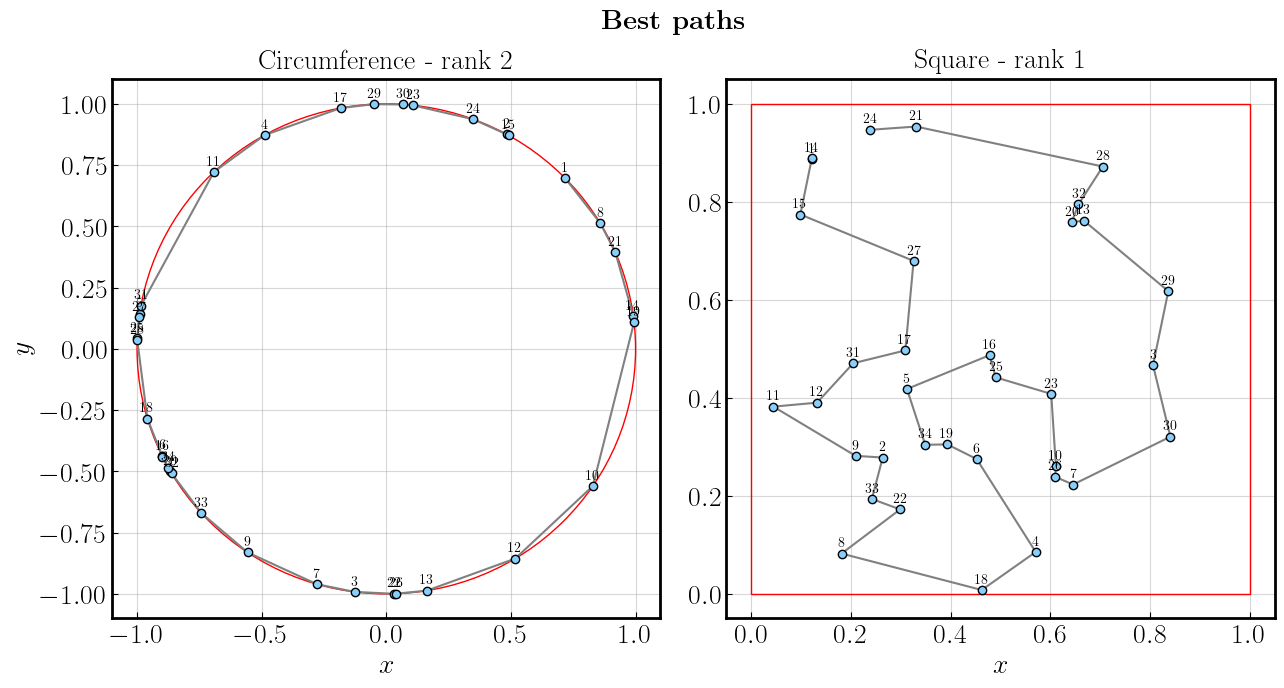

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15,7), gridspec_kw={'wspace':0.12})
fig.suptitle(r'\textbf{Best paths}')

circle = patches.Circle((0, 0), radius=1, edgecolor='r', facecolor='none')
axs[0].add_patch(circle)
ord_x_circ = x_circ[index_circ[-1,:].astype(int)]
ord_y_circ = y_circ[index_circ[-1,:].astype(int)]
axs[0].plot(ord_x_circ, ord_y_circ, color='grey', zorder=1)
axs[0].scatter(x_circ, y_circ, c='lightskyblue', zorder=2)

for i, (x, y) in enumerate(zip(x_circ, y_circ)):
    axs[0].annotate(f'{i_circ[i].astype(int)}', (x, y), textcoords="offset points", xytext=(0,5), ha='center')

axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_title('Circumference - rank ' +str(rank_cir), pad=8)

square = patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
axs[1].add_patch(square)
ord_x_square = x_square[index_square[-1,:].astype(int)]
ord_y_square = y_square[index_square[-1,:].astype(int)]
axs[1].plot(ord_x_square, ord_y_square, color='grey', zorder=1)
axs[1].scatter(x_square, y_square, c='lightskyblue', zorder=2)

for i, (x, y) in enumerate(zip(x_square, y_square)):
    axs[1].annotate(f'{i_square[i].astype(int)}', (x, y), textcoords="offset points", xytext=(0,5), ha='center')

axs[1].set_xlabel('$x$')
axs[1].set_title('Square - rank ' +str(rank_squ), pad=8)


plt.show()

These are visual representations of the best paths

# Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

## Solution

In this case the resolution of the exercise is just the same as in the prevoius exercise, with the only difference that the cities are directly read from the `cities_italy.tsv` file instead of being randomly generated. I chose again to try exchanging the best paths between processes every $20$ generations and I have implemented $6$ parallel search processes. .

In [17]:
best_rank_mig = 1
best_rank_ind = 1
n_migr = 20

In [18]:
i_ita, x_ita, y_ita = np.loadtxt('10.2/cities_italy.tsv', delimiter='\t', skiprows=1, unpack=True, usecols=(0,1,2))

data_ita_mig = np.loadtxt('10.2/Output/opt_italy_rank=' +str(best_rank_mig)+ '_migr=' +str(n_migr)+ '.csv', delimiter=',', skiprows=1)
gens_ita_mig = data_ita_mig[:,0]
#best_losses_ita_mig = data_ita_mig[:,1]
index_ita_mig = np.array(data_ita_mig[:,2:])
loss_ita_mig = np.loadtxt('10.2/Output/loss_italy_rank=' +str(best_rank_mig)+ '_migr=' +str(n_migr)+'.csv', delimiter=',', skiprows=1)
loss_ita_mig = np.array(loss_ita_mig[:,1:])

data_ita_ind = np.loadtxt('10.2/Output/opt_italy_rank=' +str(best_rank_ind)+ '_migr=0.csv', delimiter=',', skiprows=1)
gens_ita_ind = data_ita_ind[:,0]
#best_losses_ita_ind = data_ita_ind[:,1]
index_ita_ind = np.array(data_ita_ind[:,2:])
loss_ita_ind = np.loadtxt('10.2/Output/loss_italy_rank=' +str(best_rank_ind)+ '_migr=0.csv', delimiter=',', skiprows=1)
loss_ita_ind = np.array(loss_ita_ind[:,1:])

In [19]:
pop_size_ita = int(loss_ita_mig.shape[1])

In [20]:
def italy_map(ax) :
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([6, 19, 36, 48], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.OCEAN, facecolor='cornflowerblue')
    ax.add_feature(cfeature.LAND, facecolor='darkseagreen')
    ax.add_feature(cfeature.COASTLINE, color='black', lw=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle='--', lw=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='cornflowerblue', linewidth=0.3)

    return ax

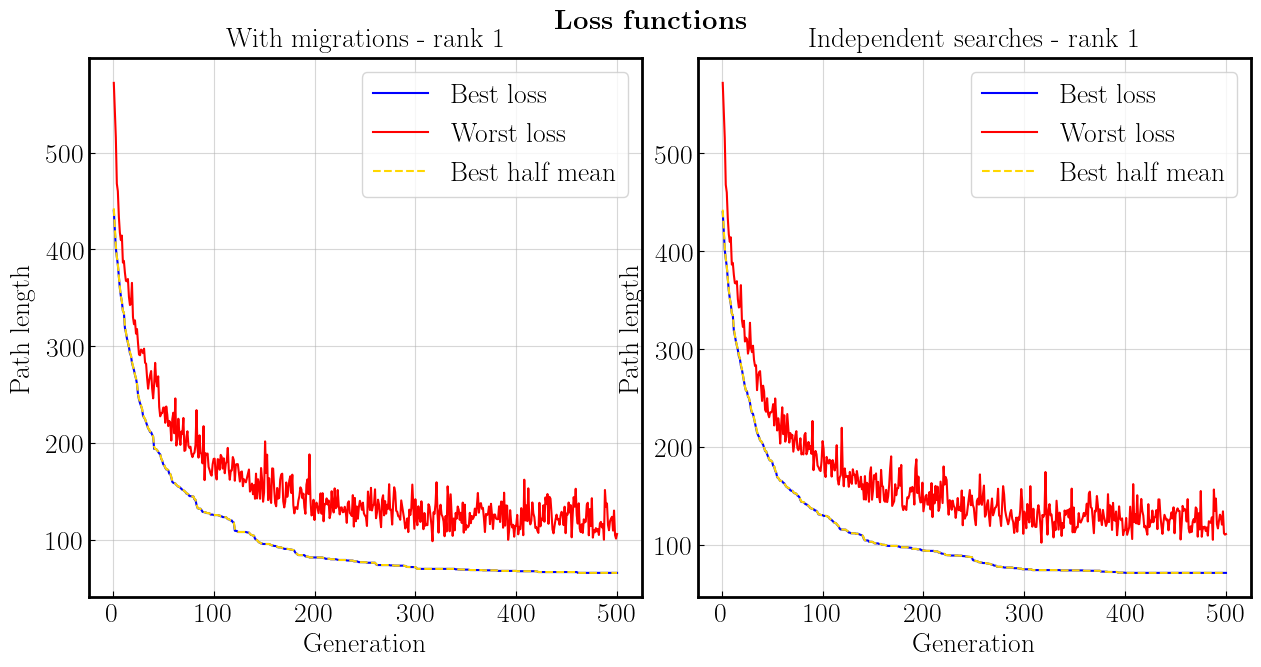

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15,7), gridspec_kw={'wspace': 0.1})
plt.suptitle(r'\textbf{Loss functions}', y=0.95)

axs[0].plot(gens_ita_mig, loss_ita_mig[:,0], c='b', label='Best loss')
axs[0].plot(gens_ita_mig, loss_ita_mig[:,-1], c='r', label='Worst loss')
axs[0].plot(gens_ita_mig, np.mean(loss_ita_mig[:,:int(pop_size/2)], axis=1), c='gold', ls='--', label='Best half mean')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Path length', labelpad=8)
axs[0].set_title('With migrations - rank ' +str(best_rank_mig), pad=8)
axs[0].legend()

axs[1].plot(gens_ita_ind, loss_ita_ind[:,0], c='b', label='Best loss')
axs[1].plot(gens_ita_ind, loss_ita_ind[:,-1], c='r', label='Worst loss')
axs[1].plot(gens_ita_ind, np.mean(loss_ita_ind[:,:int(pop_size/2)], axis=1), c='gold', ls='--', label='Best half mean')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Path length', labelpad=8)
axs[1].set_title('Independent searches - rank ' +str(best_rank_ind), pad=8)
axs[1].legend()

plt.show()

This plots show the value of the loss for the search of the best path through the $110$ italian 'capoluoghi di provincia', in the case of search with migrations (left) and of independent search processes (right) as a function of the number of generations. I plotted the values of the best loss, the worst loss and the average value of the best half of the individuals. This graphs refers to the ranks that obtained the best result.

We can note that, in both cases, after $100$ generations a good path has been discovered, and that in particular the circumference case the parallelized algorithm converges faster than in exercise $09$.

**Plot parameters**:
- Number of generations: $500$
- Population size: $300$
- Crossover probability: $0.80$
- Pair permutation probability: $0.10$
- Block permutation probability: $0.01$
- Shift probability: $0.20$
- Inversion probability: $0.20$

I calibrated empirically the probabilities for crossover and other mutations, choosing the ones that gave me the best result.

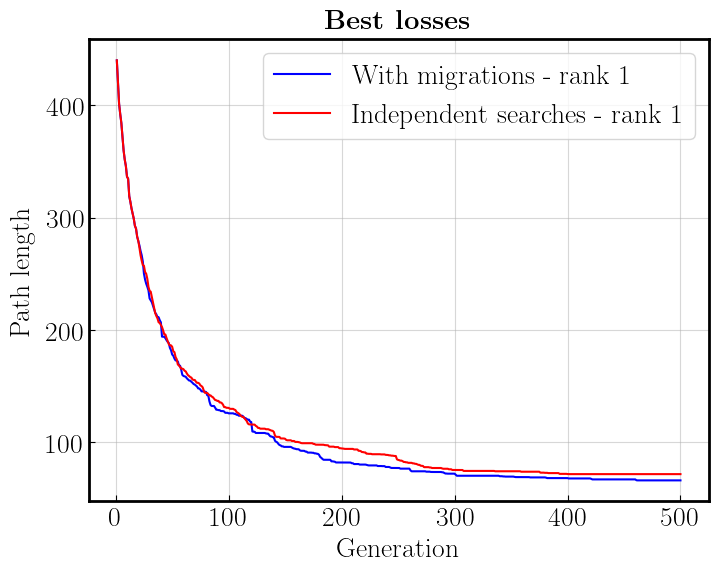

In [23]:
plt.plot(gens_ita_mig, loss_ita_mig[:,0], c='b', label='With migrations - rank ' + str(best_rank_mig))
plt.plot(gens_ita_ind, loss_ita_ind[:,0], c='r', label='Independent searches - rank ' + str(best_rank_ind))
plt.xlabel('Generation')
plt.ylabel('Path length', labelpad=8)
plt.title(r'\textbf{Best losses}', pad=8)
plt.legend()

plt.show()

Here I show the value of the best losses referring to the ranks that gave the best result, both in the case of research with migrations and of independent searches. We can see that performing migrations every $20$ generations improves slightly the best loss, as we can expect because we are in this way able to explore a wider span of the solutions space.

/opt/homebrew/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


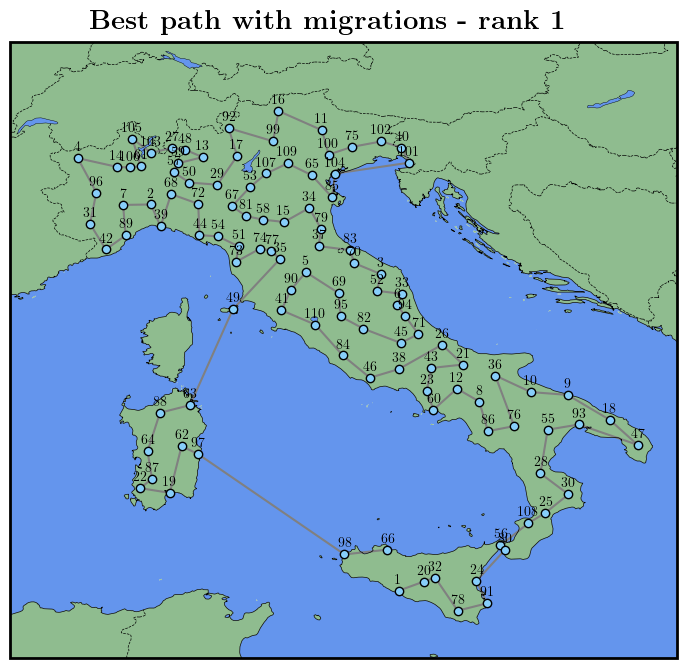

In [24]:
fig = plt.figure(figsize=(12,8))
fig.suptitle(r'\textbf{Best path with migrations - rank ' +str(best_rank_mig)+ '}', y=0.92)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([6, 19, 36, 48], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN, facecolor='cornflowerblue')
ax.add_feature(cfeature.LAND, facecolor='darkseagreen')
ax.add_feature(cfeature.COASTLINE, color='black', lw=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='--', lw=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='cornflowerblue', linewidth=0.3)


ord_x_ita = x_ita[index_ita_mig[-1,:].astype(int)]
ord_y_ita = y_ita[index_ita_mig[-1,:].astype(int)]
ax.plot(ord_x_ita, ord_y_ita, color='grey', zorder=1)
ax.scatter(x_ita, y_ita, c='lightskyblue', zorder=2)

for i, (x, y) in enumerate(zip(x_ita, y_ita)):
    ax.annotate(f'{i_ita[i].astype(int)}', (x, y), textcoords="offset points", xytext=(0,5), ha='center')


plt.show()

This is a visual representation of the best path obtained exploiting migrations, plotted over a map of italian provinces.

/opt/homebrew/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


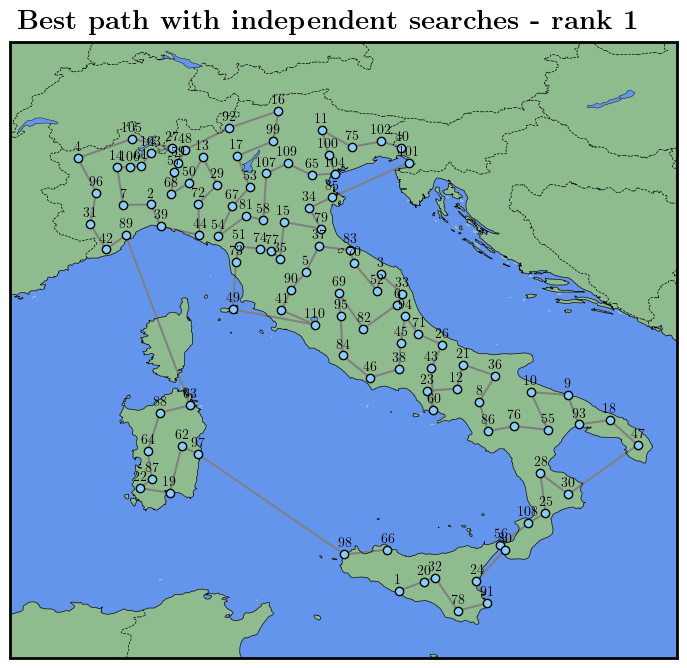

In [25]:
fig = plt.figure(figsize=(12,8))
fig.suptitle(r'\textbf{Best path with independent searches - rank ' +str(best_rank_ind)+ '}', y=0.92)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([6, 19, 36, 48], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN, facecolor='cornflowerblue')
ax.add_feature(cfeature.LAND, facecolor='darkseagreen')
ax.add_feature(cfeature.COASTLINE, color='black', lw=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='--', lw=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='cornflowerblue', linewidth=0.3)


ord_x_ita = x_ita[index_ita_ind[-1,:].astype(int)]
ord_y_ita = y_ita[index_ita_ind[-1,:].astype(int)]
ax.plot(ord_x_ita, ord_y_ita, color='grey', zorder=1)
ax.scatter(x_ita, y_ita, c='lightskyblue', zorder=2)

for i, (x, y) in enumerate(zip(x_ita, y_ita)):
    ax.annotate(f'{i_ita[i].astype(int)}', (x, y), textcoords="offset points", xytext=(0,5), ha='center')


plt.show()

This is a visual representation of the best path found with independent parallel search processes.

### Observations

The genetic algorithm seems to work very well when parallelized, even increasing the number of cities as we did in exercise $10.2$. I think that, anyway, it can be improved again, for example by:

- Increasing the number of processes involved, here I used $4$ in exercise $10.1$ and $6$ in exercise $10.2$. Increasing their number and using migrations we can enhance the variety of solutions explored.
- Automatizing the hyperparameters tuning: it can be found an automatic process that explore which are the best number of generations, population size, migration number and also sets better the probabilities associated with crossover and mutations.
- Including a final check that more than one rank have found the similar solutions: this can be useful to be sure that we are in the global minimum of the loss function.